In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot
from evogym_sim import simulate_env
from body_speciation import new_distance


In [2]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [5]:
ENV = "ObstacleTraverser-v1" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

# directory = "results/" + ENV
directory = "results/dynamic"

file = "run_1_pop_gen_10.pkl"
defaultGen = neat.DefaultGenome
f = lambda self, other, config: new_distance(params, morph_substrate(params), generate_robot, self, other, config)
# defaultGen.distance = f
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}
neat_config = neat.config.Config(
    defaultGen,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT_CPPN_robot.cfg"
)

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

0.9676443751892818


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  14 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
481 -0.8788844334509922


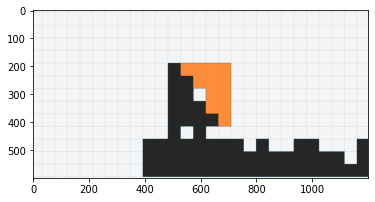

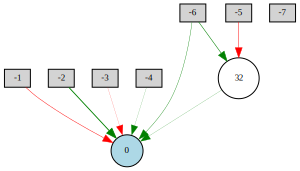

506 -0.9842359030935485


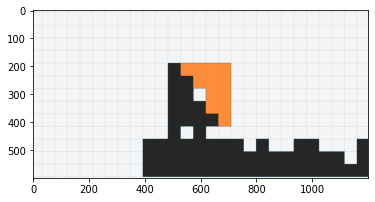

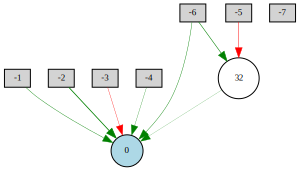

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  2 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
455 -0.8946030586250634


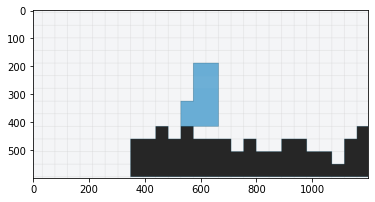

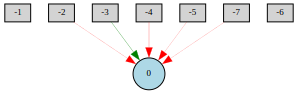

543 -0.8946030586250634


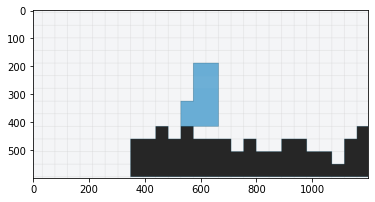

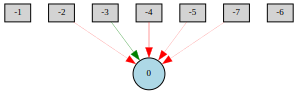

544 -3.142154570112465


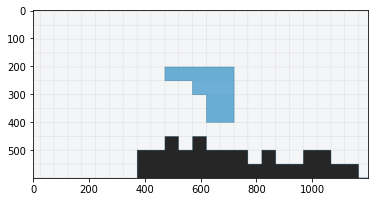

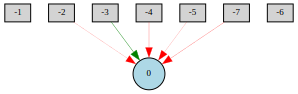

418 -0.38766457103027335


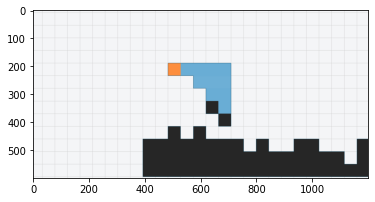

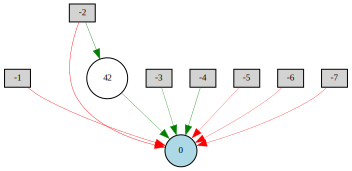

505 -4.54146502638412


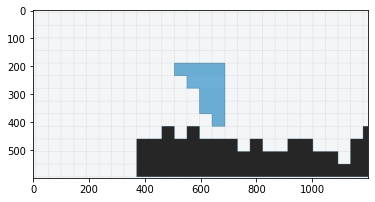

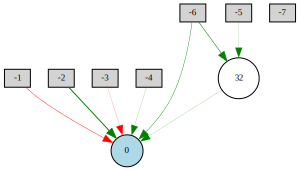

507 -2.5772955442065104


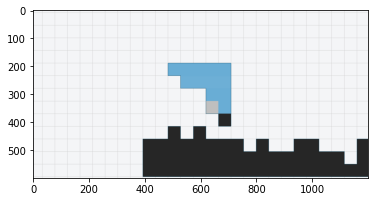

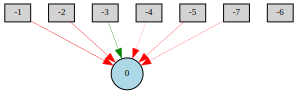

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  8 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
454 -0.28521509108407966


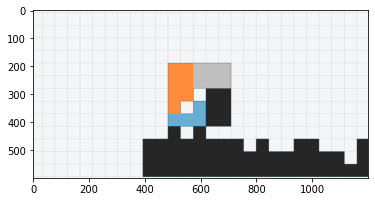

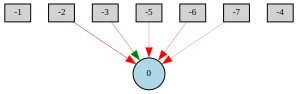

525 -1.006048385980105


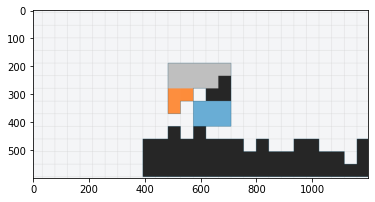

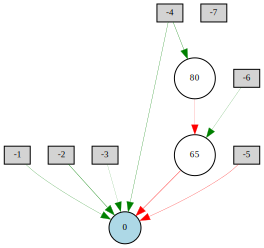

528 -0.9472185433168269


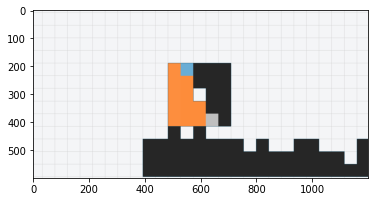

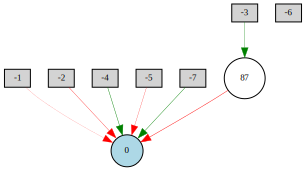

467 -0.6945323413823666


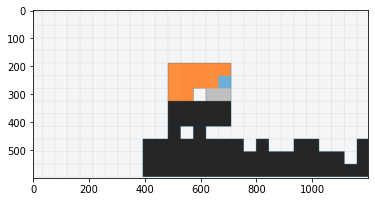

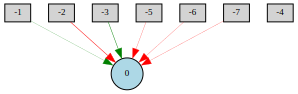

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  3 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
513 -1.1307492035994189


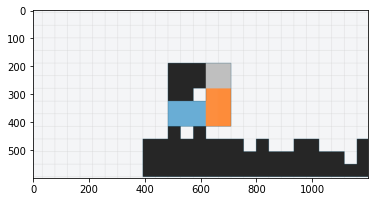

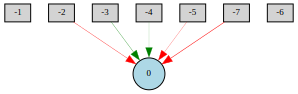

519 -0.9240508109215959


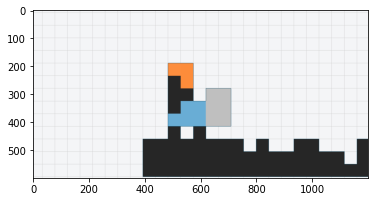

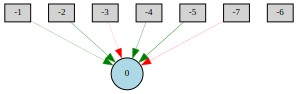

471 -0.21994854215153578


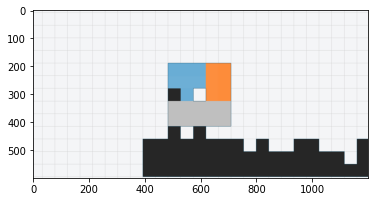

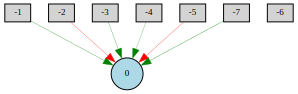

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  12 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
493 -0.23345851496971481


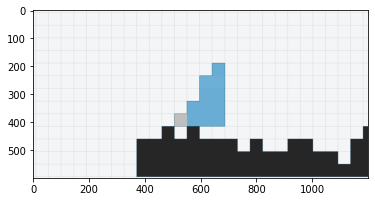

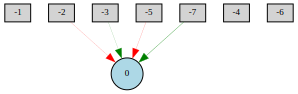

515 -0.7800636646989068


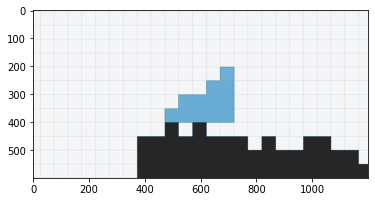

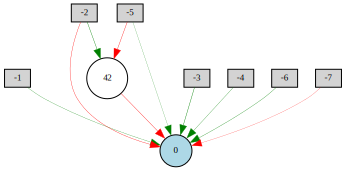

516 -0.5952529537917507


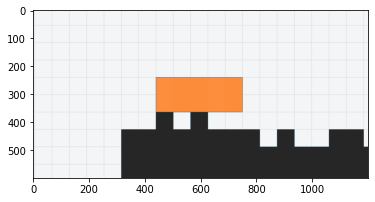

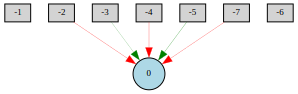

521 -0.8035910148950463


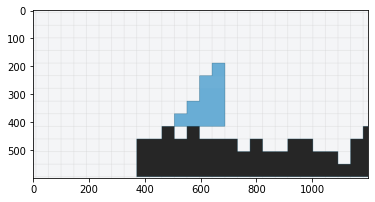

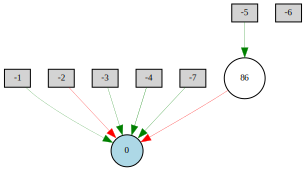

430 -0.6732636516762883


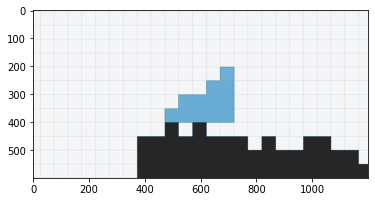

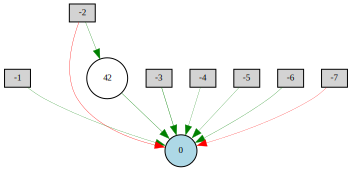

331 -0.36209206491770707


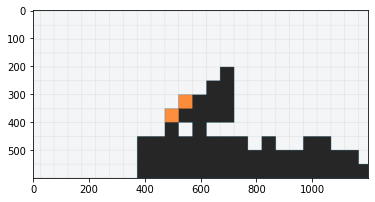

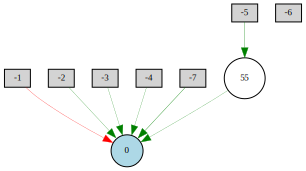

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
442 -0.7261867903088118


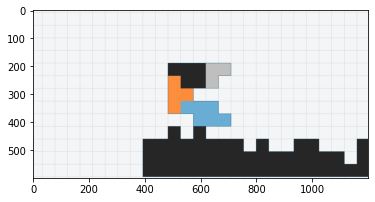

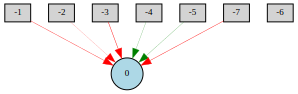

517 -0.4290960973289804


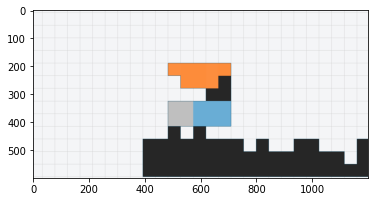

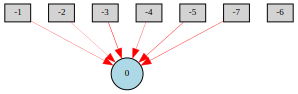

518 -0.33544887946082463


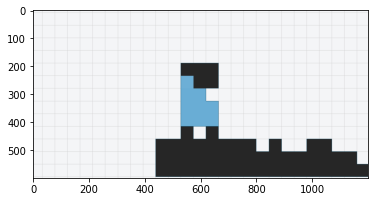

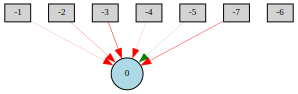

470 -0.27549303789401614


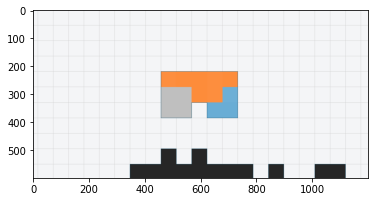

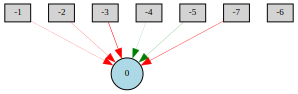

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
305 -0.18423911790057784


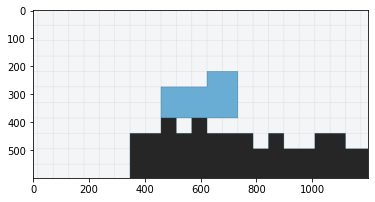

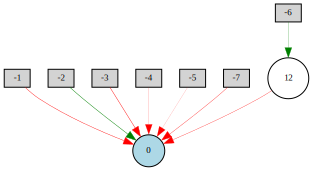

520 -0.9422509783463432


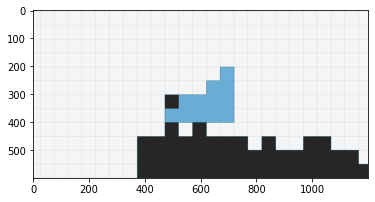

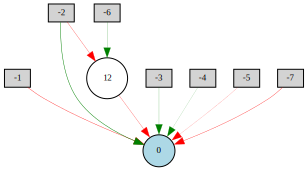

522 -0.33318004049994765


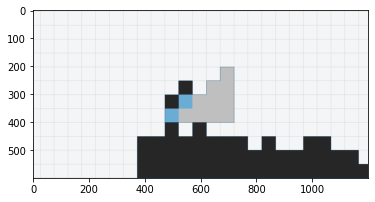

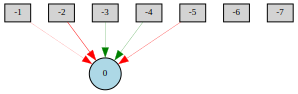

413 -0.06312983788759097


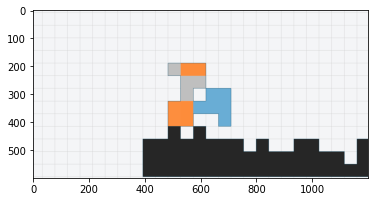

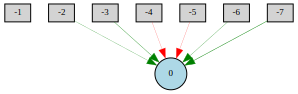

421 -0.3763051558189874


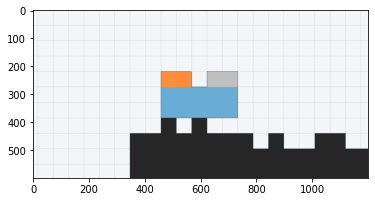

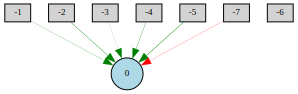

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  6 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
466 -0.377326740666969


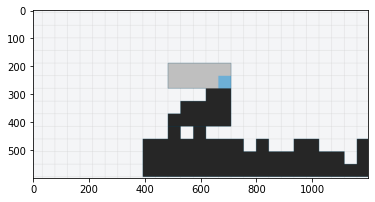

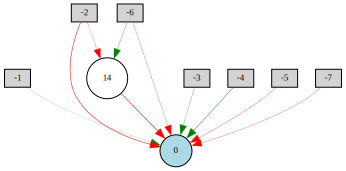

475 -0.20265327933325816


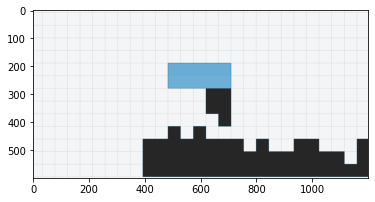

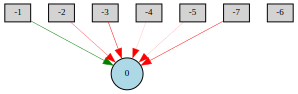

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  9 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
242 -0.20314217373986812


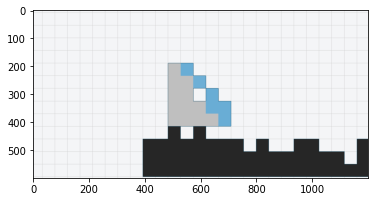

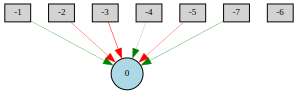

512 -1.395997355713245


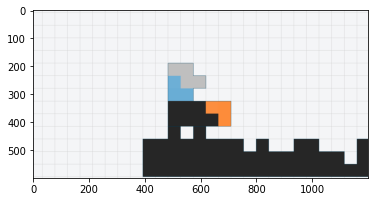

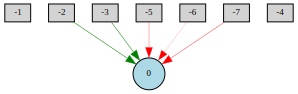

523 -0.2675506201512583


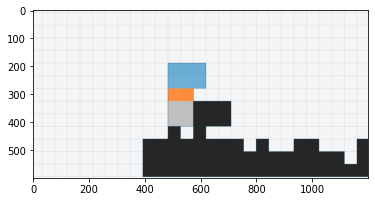

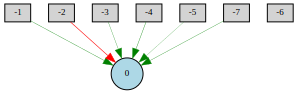

531 -0.6580102374723668


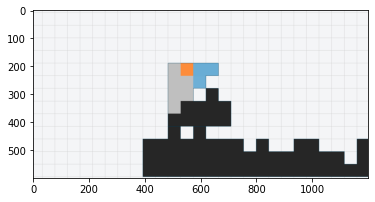

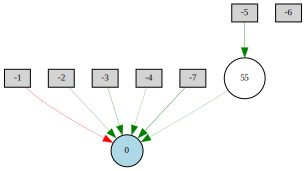

491 -0.6435908213811405


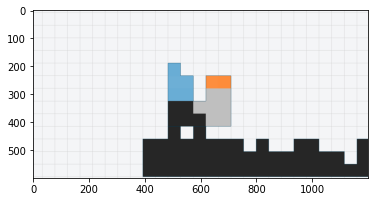

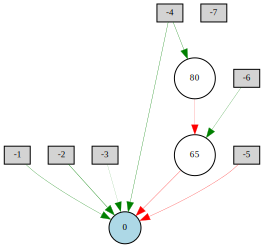

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
299 0.07059187033960301


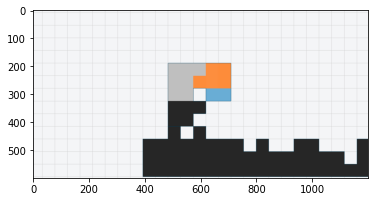

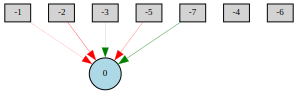

526 -0.6630448037294898


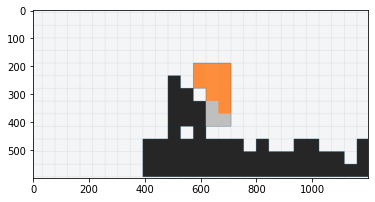

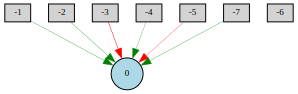

527 -0.7252443940684614


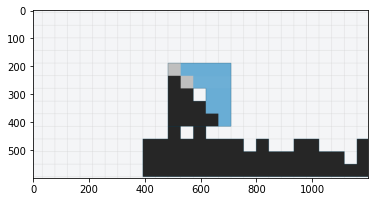

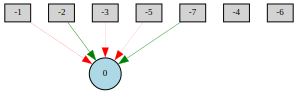

529 -0.06087303435820379


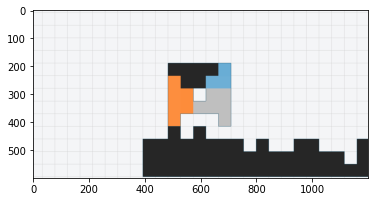

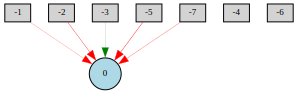

478 0.0035301453111489245


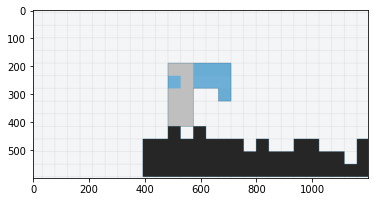

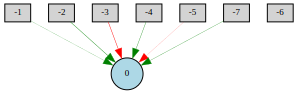

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
536 -0.39657102265933863


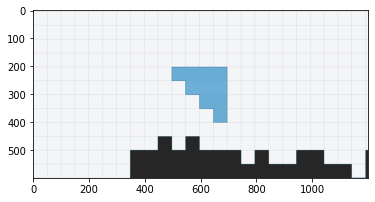

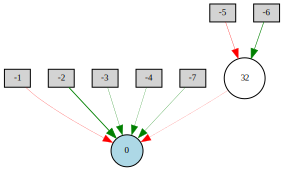

322 -0.08448578791814998


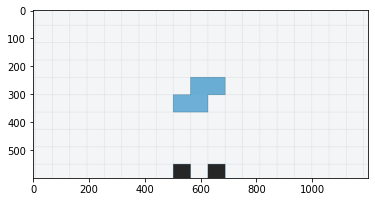

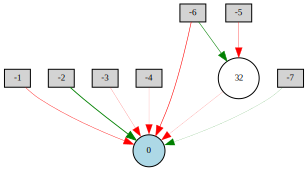

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  11 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
325 -0.4615811230002539


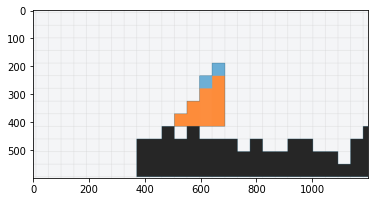

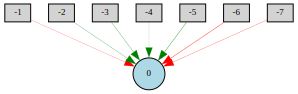

539 -0.2424509048587582


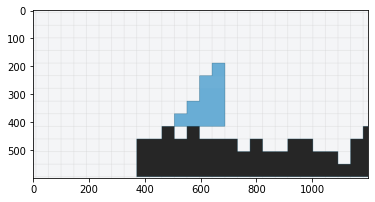

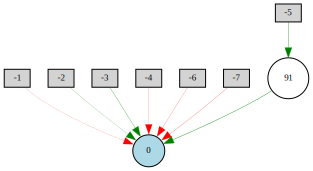

474 -0.8304080578349703


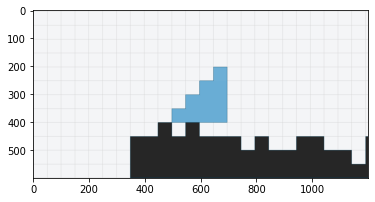

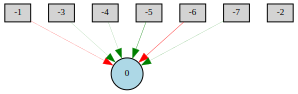

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
163 1.947985018189013


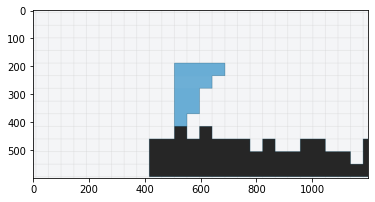

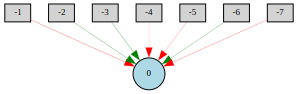

530 0.05174278098840457


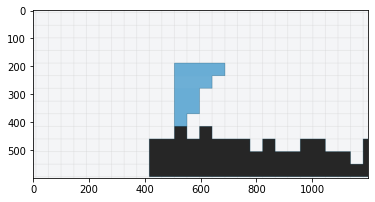

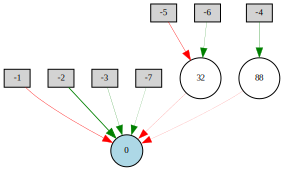

537 -0.03394762422946823


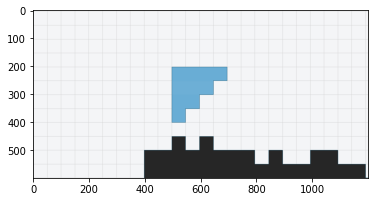

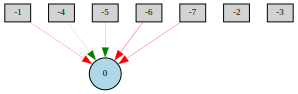

541 0.07132130955424676


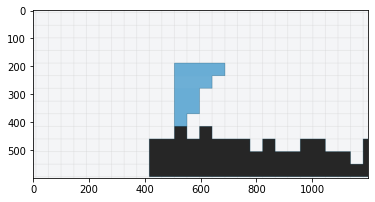

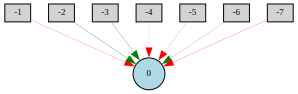

542 -0.09606392018926507


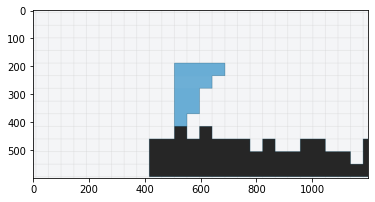

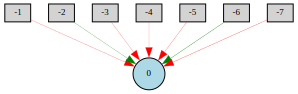

459 -0.26637442261919686


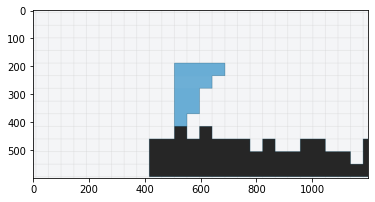

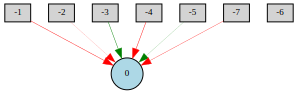

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie  13 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
509 -0.04545437923742446


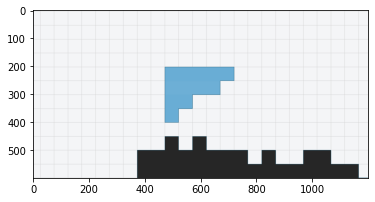

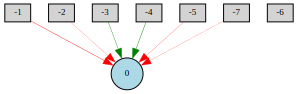

514 -0.6527153132836161


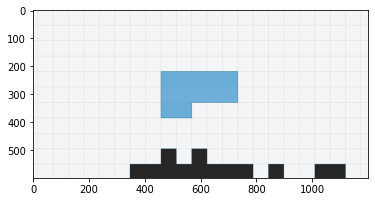

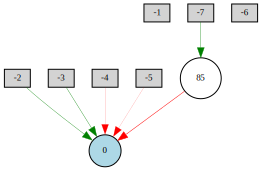

533 -1.5088160964303177


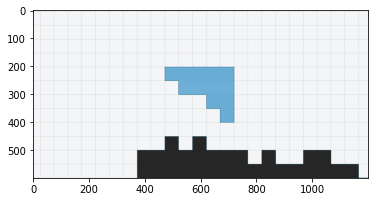

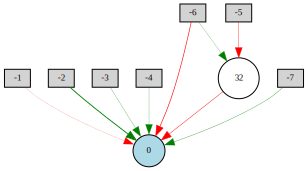

538 0.1407242945317836


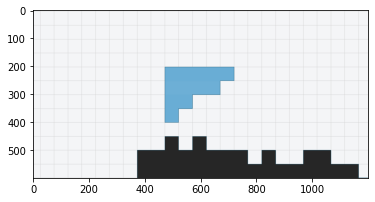

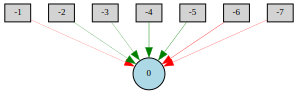

545 -0.08723954691809982


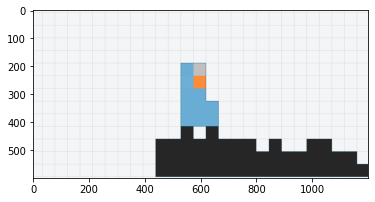

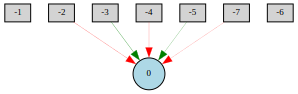

496 0.9676443751892818


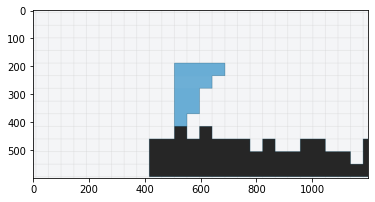

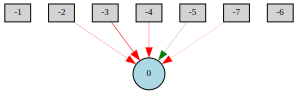

497 0.5598512724812957


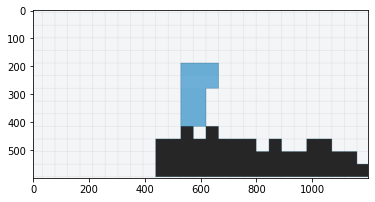

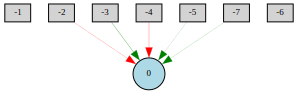

508 0.012518654156176534


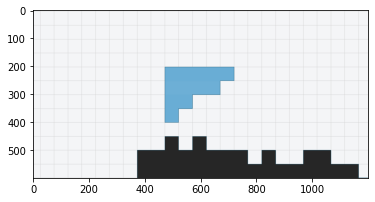

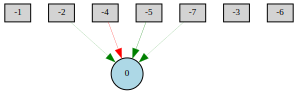

510 -0.651236994740778


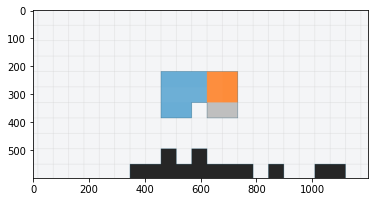

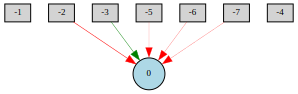

In [8]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for g in v.members.values():
        # if g.fitness != None and g.fitness > .2:
        r, img = get_robot(g, params, neat_config)
        if img is not None:
            print(g.key, g.fitness)
            plt.imshow(img)
            plt.show()
            net = neat.nn.FeedForwardNetwork.create(g, neat_config)
            display(draw_net(net))

In [9]:
# g = champion
g = pop.population[413]
params["save_to"] = "flipper_bipedal"
sgr.single_genome_fit(g, params, neat_config, True, False)
# sgr.single_genome_fit(g, params, neat_config, False, True)

(-0.06312983788759097, False)

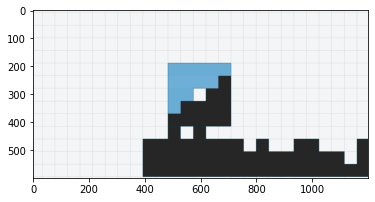

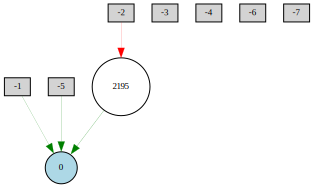

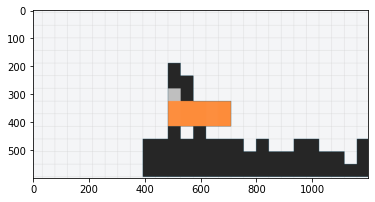

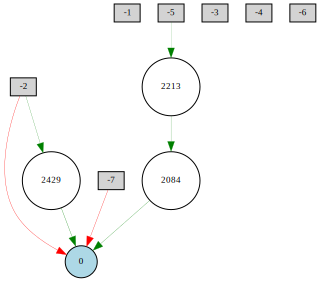

4.716327532073551

2.7363275320735507


In [8]:
base = pop.population[12892]
r2 = pop.population[14520]

_, img = get_robot(base, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(base, neat_config)
display(draw_net(net))

_, img = get_robot(r2, params, neat_config)
plt.imshow(img)
plt.show()
net = neat.nn.FeedForwardNetwork.create(r2, neat_config)
display(draw_net(net))


neat_config.compatibility_disjoint_coefficient = 1
neat_config.compatibility_weight_coefficient = .6

base.distance = f
print(base.distance(base, r2, neat_config))


print()

base.distance =  neat.DefaultGenome.distance
print(base.distance(base, r2, neat_config))
